In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from PIL import Image, ImageOps
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 
from pyomo.environ import *

## for laplacian
from scipy.sparse import csgraph

## for nullspace
from scipy.linalg import null_space

# Prepping the census and shapefile data

In [2]:
census_df=pd.read_csv('census.csv')
census_df['COUNTYFP10']=census_df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')
census_df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906
2,2,Allamakee,14061,005,43.274964,-91.382751
3,3,Appanoose,12317,007,40.744683,-92.870345
4,4,Audubon,5674,009,41.679178,-94.904312


In [3]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp').sort_values('NAME10',ignore_index=True)
shapefile_iowa.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,001,19001,Adair,Adair County,1474404167,2597997,+41.3285283,-094.4781643,7682,...,3996,1790,2114,92,3811,1133,2461,217,3,"POLYGON ((-94.35706 41.15745, -94.35992 41.157..."
1,19,003,19003,Adams,Adams County,1096700733,5353423,+41.0216555,-094.6969059,4029,...,2185,1028,1108,49,2106,565,1395,146,3,"POLYGON ((-94.81495 41.15839, -94.81268 41.158..."
2,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,+43.2749637,-091.3827510,14330,...,6934,3553,3264,117,6923,2421,4093,409,1,"POLYGON ((-91.49104 43.50071, -91.49061 43.500..."
3,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,+40.7446826,-092.8703450,12887,...,6245,2951,3161,133,6136,1814,4033,289,2,"POLYGON ((-93.09762 40.81197, -93.09761 40.812..."
4,19,009,19009,Audubon,Audubon County,1147264459,1152260,+41.6791780,-094.9043119,6119,...,3457,1611,1802,44,3412,1080,2136,196,4,"POLYGON ((-95.09316 41.68835, -95.09314 41.688..."


In [4]:
county_populations = np.array(census_df['population'])
state_population = sum(county_populations)
n_counties = 99
n_districts = 4
top_fifth_percentile=int(np.percentile(census_df['population'],95))

In [5]:
map_population_by_county_data = shapefile_iowa.merge(census_df, on='COUNTYFP10')
census_df.sort_values('population', ascending=False).head()

,county_id,county,population,COUNTYFP10,latitude,longitude
76,76,Polk,492401,153,41.684281,-93.569720
56,56,Linn,230299,113,42.077951,-91.597673
81,81,Scott,174669,163,41.641679,-90.622290
51,51,Johnson,152854,103,41.668737,-91.588812
6,6,Black Hawk,131144,013,42.472888,-92.306059


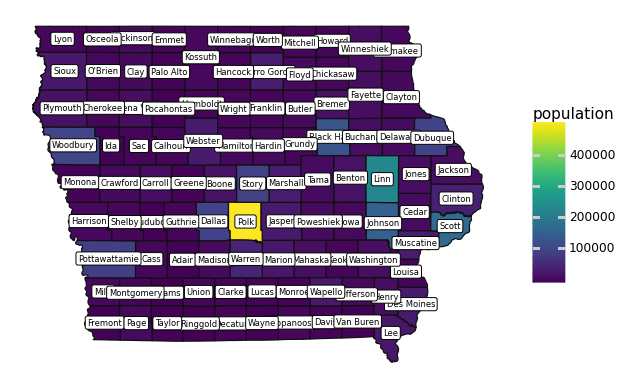

<ggplot: (8788559029950)>

In [6]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='NAME10',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

# Optimization model

## Create the adjacency matrix

In [7]:
# full statewide adjacency matrix (first boolean, then casting as int)
#   NOTE: this operation counts a county as adjacent to itself. subtract eye(99) to get a more traditional version
#   also should do this operation after any sorting of the original shapefile

ia_adjac_matrix = pd.DataFrame()

for j in range(n_counties):
    ia_adjac_matrix[j] = shapefile_iowa.intersects(shapefile_iowa.iloc[[j]].unary_union)
ia_adjac_matrix = ia_adjac_matrix - np.identity(99)
ia_adjac_matrix = ia_adjac_matrix.astype(int)

ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)



In [8]:
# zero padding county id in order to keep counties in alphabetical order for variable names
zp_county=np.array((census_df['county_id']).astype(str).str.pad(2,fillchar='0'))
zp_county

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',
       '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76',
       '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87',
       '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98'],
      dtype=object)

In [9]:
ideal_district_size=state_population/n_districts
tolerance=.01           ### changed from 0.01 to 0.05 on March 24
district_maximum=int(ideal_district_size*(1+tolerance))
district_minimum=int(ideal_district_size*(1-tolerance))

In [10]:
# # testing contiguity work

# test_list=ia_adjac_matrix_bool[ia_adjac_matrix_bool[0]==True].index.tolist()
# test_list

## Creating the model

In [11]:
model= ConcreteModel()

model.Counties = range(n_counties)
model.Districts = range(1,n_districts+1)

model.pprint()

0 Declarations: 


In [12]:
#Variable for district assignment for each county
model.Assignment=Var(model.Counties, model.Districts, domain=Boolean)
#Variable population allocation to a district for each county
model.Allocation=Var(model.Counties, model.Districts, domain=NonNegativeIntegers)

model.pprint()

model.Allocation[0,1]
### output: <pyomo.core.base.var._GeneralVarData at 0x7fc58c7b7a50>

6 Set Declarations
    Allocation_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain                                : Size : Members
        None :     2 : Allocation_index_0*Allocation_index_1 :  396 : {(0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4), (5, 1), (5, 2), (5, 3), (5, 4), (6, 1), (6, 2), (6, 3), (6, 4), (7, 1), (7, 2), (7, 3), (7, 4), (8, 1), (8, 2), (8, 3), (8, 4), (9, 1), (9, 2), (9, 3), (9, 4), (10, 1), (10, 2), (10, 3), (10, 4), (11, 1), (11, 2), (11, 3), (11, 4), (12, 1), (12, 2), (12, 3), (12, 4), (13, 1), (13, 2), (13, 3), (13, 4), (14, 1), (14, 2), (14, 3), (14, 4), (15, 1), (15, 2), (15, 3), (15, 4), (16, 1), (16, 2), (16, 3), (16, 4), (17, 1), (17, 2), (17, 3), (17, 4), (18, 1), (18, 2), (18, 3), (18, 4), (19, 1), (19, 2), (19, 3), (19, 4), (20, 1), (20, 2), (20, 3), (20, 4), (21, 1), (21, 2), (21, 3), (21, 4), (22, 1), (22, 2), (22, 3

In [13]:
# Allocate 100% of the population from each county.
model.population_allocation=ConstraintList()
for i in model.Counties:
    model.population_allocation.add(
       sum(model.Allocation[i, j] for j in model.Districts)==county_populations[i]
    )

#Create constraint list for district sizes in order to keep the size of districts by population similar
model.district_size=ConstraintList()
for j in model.Districts:
    model.district_size.add(
        sum(model.Allocation[i, j] for i in model.Counties) <= district_maximum
    )
    model.district_size.add(
        sum(model.Allocation[i, j] for i in model.Counties) >= district_minimum
    )

# Only allow counties that meet certain critera (big enough pop) to be split among multiple districts
model.district_split=ConstraintList()

#Current/recent actual Iowa districts do not split counties, so we aim to match that
#  (to force counties not to split, we could set these as <= 1 without the if statement)
for i in model.Counties:
    if county_populations[i] <= top_fifth_percentile:
        model.district_split.add(
            sum(model.Assignment[i, j] for j in model.Districts) <=1
        )
    else:
        model.district_split.add(
            sum(model.Assignment[i, j] for j in model.Districts) <=2
        )


# Constraints for contiguity
model.contiguity=ConstraintList()
# set minimum number of neighbors
neighbor_min=3          ### changed from 3 to 2 on March 24
for j in model.Districts:
    for i in model.Counties:
        county_neighbors=ia_adjac_matrix_bool[ia_adjac_matrix_bool[i]==True].index.tolist()
        model.contiguity.add(
            neighbor_min*model.Assignment[i,j] <= sum(model.Assignment[k, j] for k in county_neighbors)
        )


## new friday, march 24
# This constraint makes assignment required for allocation.
# (if assignment = 1, allocation is between 20% and 100% of total population.
#       if assignment = 2, allocation = 0)
# sum(county_populations) is the "big M"

#

model.assign4allocat = ConstraintList()
for i in model.Counties: 
    for j in model.Districts:
        model.assign4allocat.add(
            model.Allocation[i,j] <= county_populations[i]*model.Assignment[i,j]
            )
        model.assign4allocat.add(
            model.Allocation[i,j] >= 0.2*county_populations[i]*model.Assignment[i,j]
            )




# print(model.Assignment[k, 1] for k in test_list)
# model.pprint()

        

It seems possible to combine some of these constraints and specify both lower/upper bound in one constraint, which might help runtime/make things easier to parse.

Also, can we combine the model.assign4allocat.add() calls with a comma in between inequalities? or the upper/lower bounds?

In [14]:
## new friday, march 24
###    old PuLP objective function: minimize total assignments

model.obj = Objective(expr = sum(model.Assignment[i,j] for i in model.Counties for j in model.Districts), sense=minimize)

model.pprint()

11 Set Declarations
    Allocation_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain                                : Size : Members
        None :     2 : Allocation_index_0*Allocation_index_1 :  396 : {(0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4), (5, 1), (5, 2), (5, 3), (5, 4), (6, 1), (6, 2), (6, 3), (6, 4), (7, 1), (7, 2), (7, 3), (7, 4), (8, 1), (8, 2), (8, 3), (8, 4), (9, 1), (9, 2), (9, 3), (9, 4), (10, 1), (10, 2), (10, 3), (10, 4), (11, 1), (11, 2), (11, 3), (11, 4), (12, 1), (12, 2), (12, 3), (12, 4), (13, 1), (13, 2), (13, 3), (13, 4), (14, 1), (14, 2), (14, 3), (14, 4), (15, 1), (15, 2), (15, 3), (15, 4), (16, 1), (16, 2), (16, 3), (16, 4), (17, 1), (17, 2), (17, 3), (17, 4), (18, 1), (18, 2), (18, 3), (18, 4), (19, 1), (19, 2), (19, 3), (19, 4), (20, 1), (20, 2), (20, 3), (20, 4), (21, 1), (21, 2), (21, 3), (21, 4), (22, 1), (22, 2), (22, 

### Making the contiguity/laplacian objective function

In [15]:
#Objective function converted from PuLP model

#create list of empty lists. Each list will be populated with county IDs of the district corresponding to the list entry's index
# dist_counties_index=[]
# for i in model.Districts:
#     dist_counties_index.append([])

# # #grab the county ID of each county in district i
# for j in model.Districts:
#     for i in model.Counties:
#         if model.Assignment[i,j]==1:
#             dist_counties_index[j].append(i)

# district_laplacians=[]
# laplacian_kernels=[]
# conn_components=[]
# for j in model.Districts:
#     #Grabs the submatrix from IA adjacency matrix corresponding to each district and computes the laplacian of the submatrix and appends to a list of laplacians
#     district_laplacians.append(csgraph.laplacian(ia_adjac_matrix.loc[dist_counties_index[j], dist_counties_index[j]].to_numpy()))
#     laplacian_kernels.append(null_space(district_laplacians[j]))
#     conn_components.append(null_space(district_laplacians[j]).shape[1])

In [16]:
# def connected_components(assignment, districts, counties, adjacency_matrix):
#     dist_counties_index=[]
#     district_laplacians=[]
#     laplacian_kernels=[]
#     conn_components=[]

#     # create list of empty lists. Each list will be populated with county IDs of the district corresponding to the list entry's index
#     for i in districts:
#         dist_counties_index.append([])

#     # #grab the county ID of each county in district i
#     for j in districts:
#         for i in counties:
#             if assignment[i,j]==1:
#                 dist_counties_index[j].append(i)

#     for j in districts:
#         #Grabs the submatrix from IA adjacency matrix corresponding to each district and    computes the laplacian of the submatrix and appends to a list of laplacians
#         district_laplacians.append(csgraph.laplacian(adjacency_matrix.loc[dist_counties_index[j], dist_counties_index[j]].to_numpy()))
#         laplacian_kernels.append(null_space(district_laplacians[j]))
#         conn_components.append(null_space(district_laplacians[j]).shape[1])
#     return sum(conn_components)

In [17]:
# # This objective minimizes the counties split among multiple districts.
# objective_function = connected_components(model.Assignment, model.Districts, model.Counties, ia_adjac_matrix)
# # objective_function
# model.obj= Objective(expr = objective_function)

## Running the model

In [18]:
# results = SolverFactory('glpk').solve(model)

solver = SolverFactory('cbc')
solver.solve(model)

# running on Nate's old laptop:
# 27 minutes, "System time': 1624.6, 'Wallclock time': 1635.7
# Number of iterations: 9703279

{'Problem': [{'Name': 'unknown', 'Lower bound': 99.0, 'Upper bound': 99.0, 'Number of objectives': 1, 'Number of constraints': 1394, 'Number of variables': 792, 'Number of binary variables': 396, 'Number of integer variables': 792, 'Number of nonzeros': 396, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 1624.6, 'Wallclock time': 1635.7, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 68031, 'Number of created subproblems': 68031}, 'Black box': {'Number of iterations': 9703279}}, 'Error rc': 0, 'Time': 1635.7667074203491}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [19]:
# arbitrary assignment/allocation value:
# value(model.Assignment[67,2])


# end value of objective function ("model.obj"): in this case, number of district/county pairs.
# 99 means no splits
value(model.obj)

99.0

## Preparing data and visualizing results: adapted/coped from PuLP verion

In [21]:
# Prepare data for visualizing the results 

result_value = []
for i in range(n_counties):
    for j in range(1,n_districts+1):
        var_output = {
            'county_id': i,
            'district': j,
            'assignment': int(value(model.Assignment[i,j])*(j)),
            'allocation': value(model.Allocation[i,j])}
        result_value.append(var_output)
        
results = pd.DataFrame(result_value)
results = results[results['assignment'] != 0]
results = results.sort_values(['county_id', 'district'])
results


,county_id,district,assignment,allocation
3,0,4,4,7496.0
4,1,1,1,3704.0
9,2,2,2,14061.0
14,3,3,3,12317.0
18,4,3,3,5674.0
...,...,...,...,...
376,94,1,1,10679.0
381,95,2,2,20070.0
386,96,3,3,105941.0
388,97,1,1,7443.0


In [22]:
results = results.merge(census_df, on='county_id')
results

,county_id,district,assignment,allocation,county,population,COUNTYFP10,latitude,longitude
0,0,4,4,7496.0,Adair,7496,001,41.328528,-94.478164
1,1,1,1,3704.0,Adams,3704,003,41.021656,-94.696906
2,2,2,2,14061.0,Allamakee,14061,005,43.274964,-91.382751
3,3,3,3,12317.0,Appanoose,12317,007,40.744683,-92.870345
4,4,3,3,5674.0,Audubon,5674,009,41.679178,-94.904312
...,...,...,...,...,...,...,...,...,...
94,94,1,1,10679.0,Winnebago,10679,189,43.378124,-93.743488
95,95,2,2,20070.0,Winneshiek,20070,191,43.292989,-91.850788
96,96,3,3,105941.0,Woodbury,105941,193,42.393220,-96.053296
97,97,1,1,7443.0,Worth,7443,195,43.373491,-93.248533


In [23]:
# should be empty if no counties are split
results.loc[(results['allocation'])!=(results['population'])]

,county_id,district,assignment,allocation,county,population,COUNTYFP10,latitude,longitude


In [24]:
color_dict = { 1 : 'red',
               2 : 'green',
               3 : 'pink',
               4 : 'blue',
               }

def iowa_map(map_data):
    """
    Create three maps to visualize the results.  
    (1) A map with county IDs labels
    (2) A map with county labels
    """
    plot_map_population_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county_id',size=2), show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    # plot_map_county_ids = (
    #     ggplot(map_data)
    # + geom_map(aes(fill=str('Assignment'))) 
    # + geom_label(aes(x='longitude', y='latitude', label='population', size=5), 
    #              show_legend=False)
    # + theme_minimal()
    # + theme(axis_text_x=element_blank(),
    #         axis_text_y=element_blank(),
    #         axis_title_x=element_blank(),
    #         axis_title_y=element_blank(),
    #         axis_ticks=element_blank(),
    #         panel_grid_major=element_blank(),
    #         panel_grid_minor=element_blank(),
    #         figure_size=(7, 4))
    # + scale_fill_manual(values=color_dict))
    
    return plot_map_population_labels, plot_map_county_labels
# , plot_map_county_ids


In [25]:
shapefile_and_assignments = shapefile_iowa.merge(results, on='COUNTYFP10')
# map_first_pass['District'] = map_first_pass['District']+1
shapefile_and_assignments.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,CD,geometry,county_id,district,assignment,allocation,county,population,latitude,longitude
0,19,001,19001,Adair,Adair County,1474404167,2597997,+41.3285283,-094.4781643,7682,...,3,"POLYGON ((-94.35706 41.15745, -94.35992 41.157...",0,4,4,7496.0,Adair,7496,41.328528,-94.478164
1,19,003,19003,Adams,Adams County,1096700733,5353423,+41.0216555,-094.6969059,4029,...,3,"POLYGON ((-94.81495 41.15839, -94.81268 41.158...",1,1,1,3704.0,Adams,3704,41.021656,-94.696906
2,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,+43.2749637,-091.3827510,14330,...,1,"POLYGON ((-91.49104 43.50071, -91.49061 43.500...",2,2,2,14061.0,Allamakee,14061,43.274964,-91.382751
3,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,+40.7446826,-092.8703450,12887,...,2,"POLYGON ((-93.09762 40.81197, -93.09761 40.812...",3,3,3,12317.0,Appanoose,12317,40.744683,-92.870345
4,19,009,19009,Audubon,Audubon County,1147264459,1152260,+41.6791780,-094.9043119,6119,...,4,"POLYGON ((-95.09316 41.68835, -95.09314 41.688...",4,3,3,5674.0,Audubon,5674,41.679178,-94.904312


In [26]:
# map_first_pass['District'] = map_first_pass['District'].astype('category')
shapefile_and_assignments['assignment'] = shapefile_and_assignments['assignment'].astype("category")

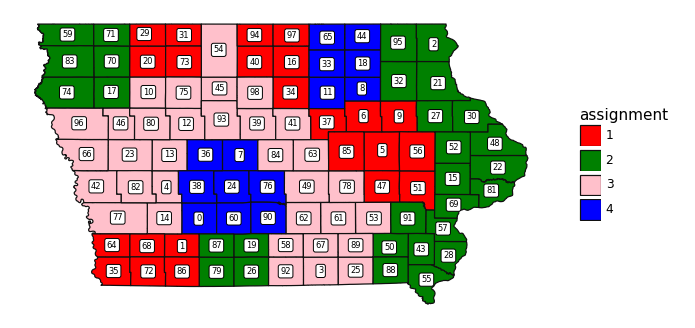

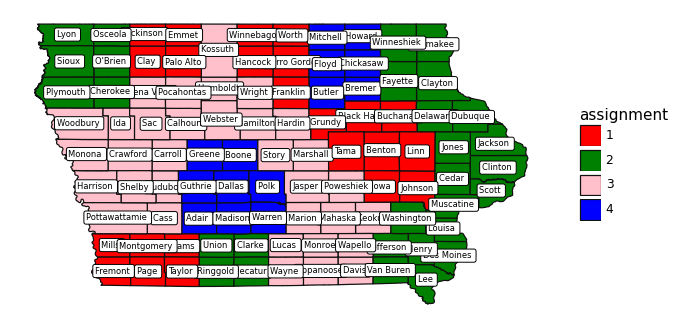

(<ggplot: (8788556225904)>, <ggplot: (8788556201524)>)

In [27]:
iowa_map(shapefile_and_assignments)

In [28]:
district_totals = pd.DataFrame(results.groupby('district')['allocation'].sum().astype('int64'))
district_totals

,allocation
district,
1,797327
2,799382
3,792030
4,801630
